In [30]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import cm
from tqdm import tqdm

import urllib
from urllib.error import HTTPError
from deap import tools

%matplotlib inline

## Benchmark functions

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])


# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)


# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)


# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

## Ploting

In [13]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [3]:
def plot_mutation(
    objective_function,
    mutations,
    original_individual,
    title,
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
):
   
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

    plt.figure(figsize=(7, 7))
    plt.contour(X, Y, Z, 50)
    plt.scatter(mutations[:, 0], mutations[:, 1], edgecolor='black')
    plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
    plt.title(title)
    plt.show()

## Mutation 1
$x_i = x_i + \varepsilon_i$,  $\varepsilon_i$ ~ $\mathcal{N}(0, \sigma^2)$,  $\sigma$ fixed for all $i = 1, 2, \ldots, d$

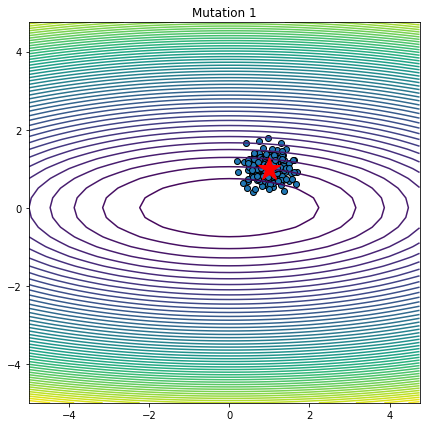

In [4]:
N = 250
d = 2
sigma = 0.25

original_individual = np.array([[1, 1]])
mutations1 = original_individual + sigma * np.random.randn(N, d)

plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations1,
    original_individual = original_individual,
    title = 'Mutation 1',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Mutation 2

$x_i = x_i + \varepsilon_i$,  $\varepsilon_i$ ~ $\mathcal{N}(0, \sigma^2)$,  $\sigma$ can be different for all $i = 1, 2, \ldots, d$

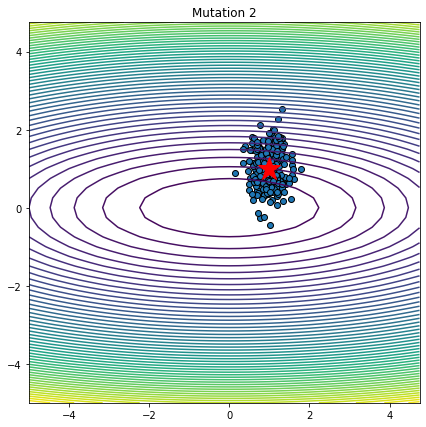

In [5]:
N = 250
d = 2
sigma = np.array([0.25, 0.5])

original_individual = np.array([[1, 1]])
mutations2 = original_individual + sigma * np.random.randn(N, d)


plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations2,
    original_individual = original_individual,
    title = 'Mutation 2',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Mutation 3

$\mathbf{x} = \mathbf{x} + \boldsymbol{\varepsilon}$, where $\boldsymbol{\varepsilon}$ has multidimentional normal distribution $\mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$

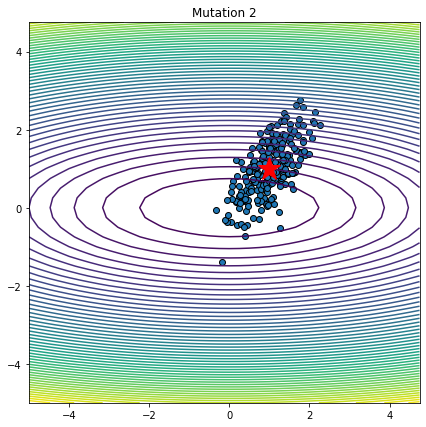

In [6]:
N = 250
d = 2
sigma = np.array([0.25, 0.5])

original_individual = np.array([[1, 1]])
S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations3 = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)


plot_mutation(
    objective_function = objective_function_F1a,
    mutations = mutations3,
    original_individual = original_individual,
    title = 'Mutation 2',
    domain_X = np.arange(-5, 5, 0.25), 
    domain_Y = np.arange(-5, 5, 0.25),
)

## Describe mutations

In [46]:
def test_mutation(
    mutation,
    objective_function,
    original_individual,
):
    scores = objective_function(mutation)
    original_individual_score = objective_function(original_individual)
    
    better_indi = np.sum(scores > original_individual_score)
    best_indi = scores.max()
    worst_indi = scores.min()
    mean_indi = scores.mean()
    print(f'Better individuals after mutation {better_indi} / {mutation.shape[0]}')
    print(f'Best score: {best_indi} | Worst: {worst_indi} | Mean {mean_indi}')
    print()
    
    
    
def plot_elipses(
    ax,
    mutations, 
    original_individual,
    n_std=2,
    facecolor='none',
    **kwargs
):
    x, y = mutations.T
    cov = np.cov(x, y)
    pearson = cov[0, 1]/(np.sqrt(cov[0, 0] * cov[1, 1])+1e-10)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs
    )

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)
    
#     ax.scatter(mutations[:, 0], mutations[:, 1], edgecolor='black')
#     ax.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
#     plt.show()

In [51]:
original_individual = np.array([[1, 1]])
mutations = [mutations1, mutations2, mutations3]
objective_functions = [
    objective_function_F1, 
    objective_function_F1a, 
    objective_function_F1b, 
    objective_function_F1c,
]

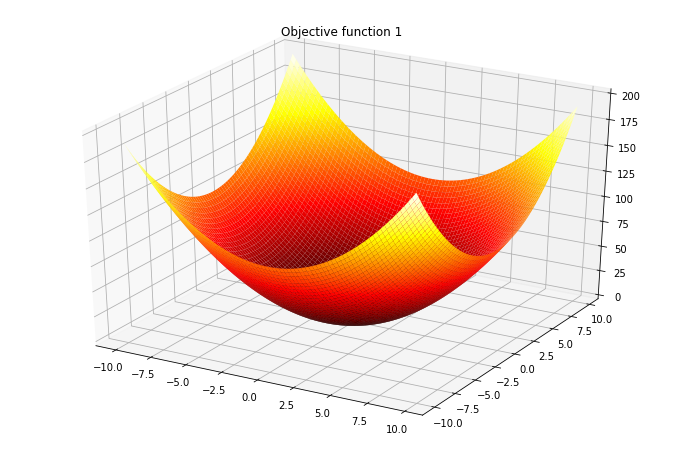

Mutation 1
Better individuals after mutation 111 / 250
Best score: -1.7739457293702303 | Worst: -29.978671828956376 | Mean -10.971848853225751



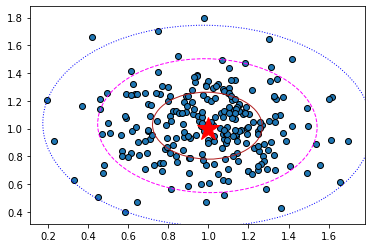

Mutation 2
Better individuals after mutation 116 / 250
Best score: -0.6800238791212222 | Worst: -58.78496508372806 | Mean -12.832239625625945



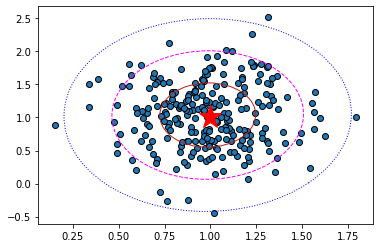

Mutation 3
Better individuals after mutation 126 / 250
Best score: -0.059104217458711944 | Worst: -71.03527239731011 | Mean -14.493273534121647



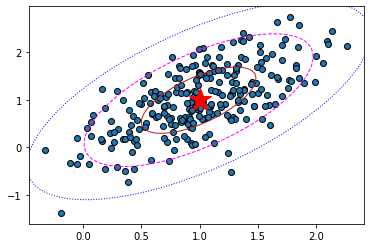

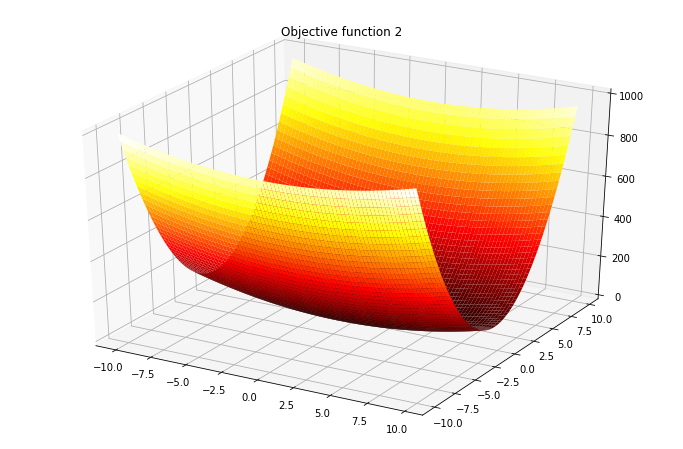

Mutation 1
Better individuals after mutation 111 / 250
Best score: -1.7739457293702303 | Worst: -29.978671828956376 | Mean -10.971848853225751



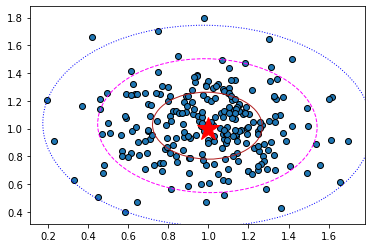

Mutation 2
Better individuals after mutation 116 / 250
Best score: -0.6800238791212222 | Worst: -58.78496508372806 | Mean -12.832239625625945



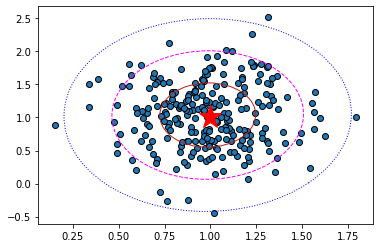

Mutation 3
Better individuals after mutation 126 / 250
Best score: -0.059104217458711944 | Worst: -71.03527239731011 | Mean -14.493273534121647



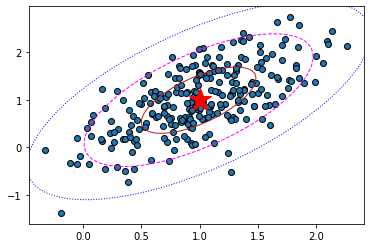

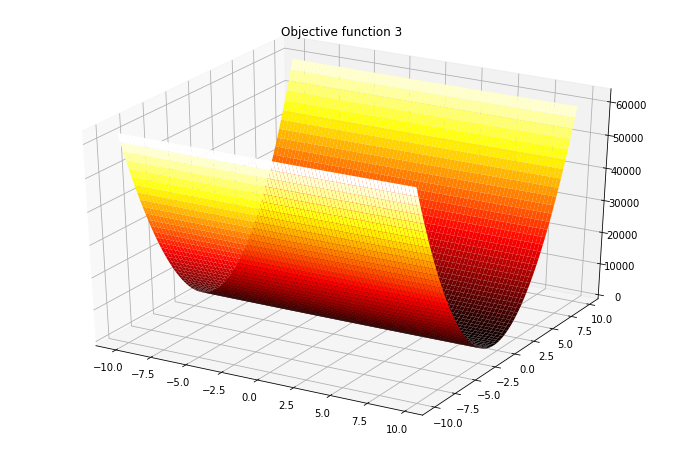

Mutation 1
Better individuals after mutation 111 / 250
Best score: -1.7739457293702303 | Worst: -29.978671828956376 | Mean -10.971848853225751



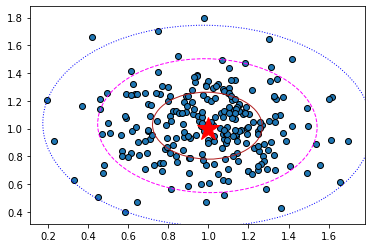

Mutation 2
Better individuals after mutation 116 / 250
Best score: -0.6800238791212222 | Worst: -58.78496508372806 | Mean -12.832239625625945



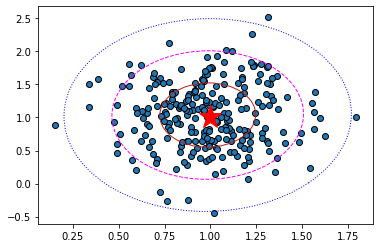

Mutation 3
Better individuals after mutation 126 / 250
Best score: -0.059104217458711944 | Worst: -71.03527239731011 | Mean -14.493273534121647



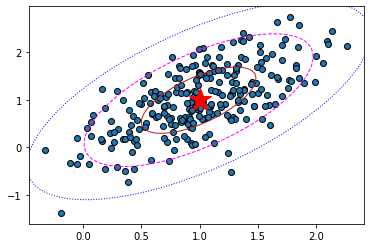

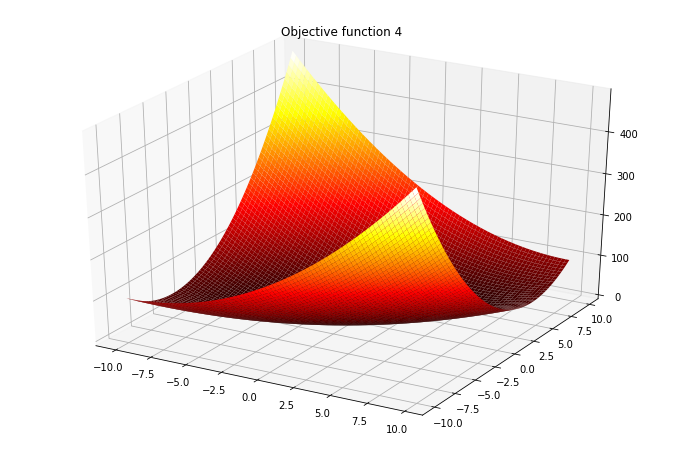

Mutation 1
Better individuals after mutation 111 / 250
Best score: -1.7739457293702303 | Worst: -29.978671828956376 | Mean -10.971848853225751



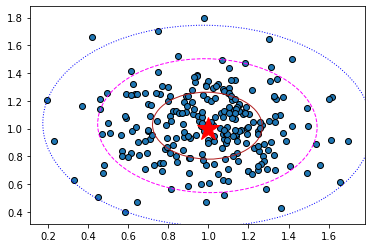

Mutation 2
Better individuals after mutation 116 / 250
Best score: -0.6800238791212222 | Worst: -58.78496508372806 | Mean -12.832239625625945



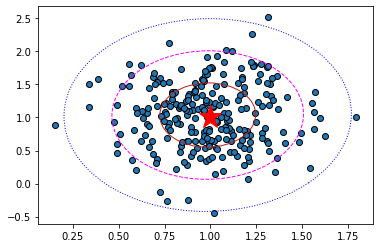

Mutation 3
Better individuals after mutation 126 / 250
Best score: -0.059104217458711944 | Worst: -71.03527239731011 | Mean -14.493273534121647



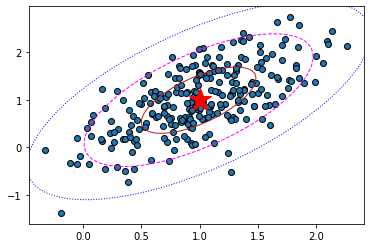

In [52]:
 for i, objective_function in enumerate(objective_functions):
    plot_3D_benchmark_function(
        objective_function = objective_function,
        domain_X = np.arange(-10, 10, 0.25), 
        domain_Y = np.arange(-10, 10, 0.25),
        title = f'Objective function {i + 1}'
    )
    for j, mutation in enumerate(mutations):
        print(f'Mutation {j + 1}')
        test_mutation(
            mutation=mutation,
            objective_function = objective_function_F1a,
            original_individual = original_individual
        )
        
        fig, ax = plt.subplots()
        ax.scatter(mutation[:, 0], mutation[:, 1], edgecolor='black')
        ax.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24, color='red')
        
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 1,
            edgecolor='firebrick'
        )
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 2,
            edgecolor='fuchsia', 
            linestyle='--'
        )
        plot_elipses(
            ax=ax,
            mutations = mutation,
            original_individual = original_individual,
            n_std = 3,
            edgecolor='blue', 
            linestyle=':'
        )
        plt.show()